In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('data.csv')
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

#Rain binary classification
if 'Total Precip (in)' in df.columns:
    df['Total Precip (in)'] = df['Total Precip (in)'].fillna(0)
    df['Has_Precip'] = (df['Total Precip (in)'] > 0).astype(int)

df['Hour'] = df['Date/Time'].dt.hour
df['Month'] = df['Date/Time'].dt.month
df['Day_of_Year'] = df['Date/Time'].dt.dayofyear
df['Day_of_Week'] = df['Date/Time'].dt.dayofweek

# Handle wind direction - convert to sine and cosine components
if 'Wind Direction (°)' in df.columns:
    # Fill missing values with the median
    wind_dir_median = df['Wind Direction (°)'].median()
    df['Wind Direction (°)'] = df['Wind Direction (°)'].fillna(wind_dir_median)
    
    # Convert to sine and cosine components
    df['Wind_Sin'] = np.sin(np.radians(df['Wind Direction (°)']))
    df['Wind_Cos'] = np.cos(np.radians(df['Wind Direction (°)']))

# Convert pressure trend code to numerical if it exists
if 'Pressure Trend Code' in df.columns:
    trend_map = {'F': -1, 'S': 0, 'R': 1}
    # Handle missing or unexpected values
    df['Pressure_Trend_Num'] = df['Pressure Trend Code'].map(trend_map).fillna(0)

len(df)

41454

In [7]:
columns_to_isolate = ['Wind_Cos', 'Wind_Sin', 'Wind Direction (°)', 'Hourly Precip (in)', 'Hour', 'Month',"Has_Precip"]
filtered_df = df[columns_to_isolate]
filtered_df["Has_Precip"].value_counts()

Has_Precip
0    40948
1      506
Name: count, dtype: int64

In [8]:
# turn it into a numpy array for ML purposes
filtered_array = filtered_df.to_numpy()
filtered_array



array([[-5.00000000e-01, -8.66025404e-01,  2.40000000e+02, ...,
         5.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-3.42020143e-01, -9.39692621e-01,  2.50000000e+02, ...,
         6.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.83697020e-16, -1.00000000e+00,  2.70000000e+02, ...,
         7.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       ...,
       [ 9.39692621e-01, -3.42020143e-01,  3.40000000e+02, ...,
         2.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 9.84807753e-01, -1.73648178e-01,  3.50000000e+02, ...,
         3.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-7.66044443e-01, -6.42787610e-01,  2.20000000e+02, ...,
         4.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

In [9]:
# min-max scaling
post_process = filtered_array
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(post_process).round(2)
X_scale = np.hstack((X_scale, np.ones((X_scale.shape[0], 1))))


In [10]:
phi = np.concatenate((X_scale[:, :-2], X_scale[:, -1:]), axis=1) # All columns except second to last.
y = X_scale[:, -2]

In [11]:
Phi_train, Phi_test, y_train, y_test = train_test_split(phi, y, test_size=0.2)

In [20]:
#step size
eta = 0.01

#initializing the weights
W1 = np.random.randn(7,4)
W2 = np.random.randn(4,1)
Phi_train.shape

(33163, 7)

In [25]:
# keep track of gradient descent errors
# to monitor convergence

import math
def f(x):
    h = np.maximum(0, W1.T.dot(x))
    return 1/ (1 + math.e**(-1*(W2.T.dot(h))))

# descent
errors = []
epochs = 200
n = Phi_train.shape[0]
for epoch in range(epochs):
    dW2 = 0
    # first weight and derivative 
    for i, j in enumerate(y_train):
        #reshape first set
        x = np.reshape(Phi_train[i], (7,1))
        f_x = f(x)
        h = np.maximum(0, W1.T.dot(x))
        dW2 += (1/n) * (f_x - y_train[i])*h

    W2 = W2 - eta * dW2

    #W1 derivative
    dW1 = 0
    for i, j in enumerate(y_train):
        x = np.reshape(Phi_train[i], (7,1))
        relu_derivative = (W1.T.dot(x) > 0).astype(float)  # Derivative of ReLU
        gradient = (f_x - y_train[i]) * W2 * relu_derivative
    
        
        # Update accumulated gradient
        dW1 += (1/n) * np.outer(x,(gradient.T))

# After loop, update W1
    W1 = W1 - eta * dW1
    e = (1/n) * np.sum(np.square(f(Phi_train.T) - y_train))
    errors.append(e)

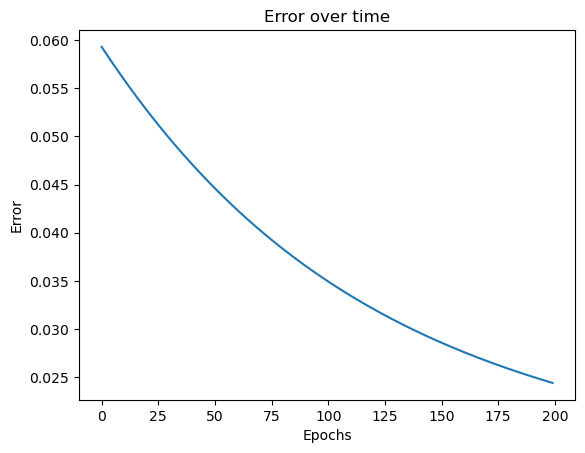

In [29]:
plt.plot(range(epochs), errors, label='line')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error over time')
plt.show()

In [28]:
accuracy = np.mean(np.round(f(Phi_test.T)) == y_test)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 98.51646363526716%


In [30]:
W1

array([[ 1.00770291,  1.11497712, -1.19839733, -0.26409841],
       [ 1.31531457, -0.94670158, -0.7463586 , -0.75293809],
       [-0.38566365, -0.13021786, -0.79224019, -0.50086359],
       [ 0.01087191, -0.30085055,  0.70774542,  0.34848171],
       [-0.51457113,  0.91329564, -0.42395508, -1.33257841],
       [-0.52766094,  1.30931578,  0.6601569 ,  0.82829805],
       [ 0.42821799,  0.23640031, -0.98461481,  0.41571586]])